In [1]:
!apt-get -y install fonts-ipafont-gothic --quiet > /dev/null 2>&1

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import scipy.stats
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
import matplotlib as mpl

In [4]:
ipa_font_path = "/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf"
ipa_font = fm.FontProperties(fname=ipa_font_path)
mpl.rcParams['axes.unicode_minus'] = False

In [5]:
# データの読み込み
digits = load_digits()
print(dir(digits))

['DESCR', 'data', 'feature_names', 'frame', 'images', 'target', 'target_names']


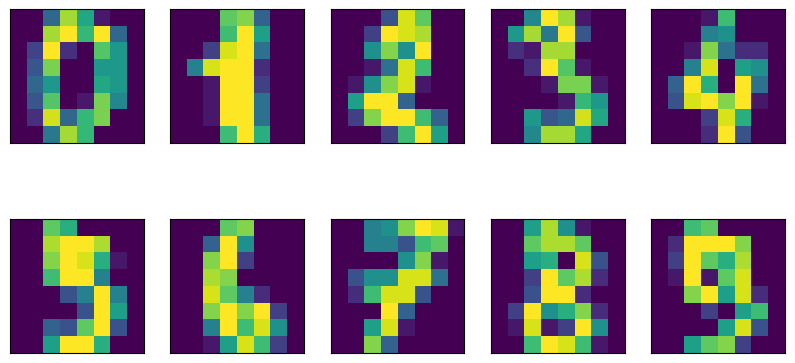

In [6]:
# 読み込んだ画像データの確認
import matplotlib.pyplot as plt
fig , axes = plt.subplots(2,5,figsize=(10,5),
                        subplot_kw={'xticks':(),'yticks':()})
for ax,img in zip(axes.ravel(),digits.images):
   ax.imshow(img)
plt.show()

In [7]:
X = digits.data
y = digits.target

In [8]:
# 訓練・テストに分割
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0, stratify=y)

In [9]:
# グリッドサーチのパラメータ
grid_params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "decision_function_shape": ["ovr", "ovo"]
}

In [10]:
# ランダムサーチのパラメータ
random_params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": scipy.stats.uniform(0.00001, 1000),
    "decision_function_shape": ["ovr", "ovo"]
}

In [11]:
# グリッドサーチ実行
grid_search = GridSearchCV(SVC(), grid_params, scoring='f1_micro', n_jobs=-1)
grid_search.fit(train_X, train_y)
grid_pred = grid_search.predict(test_X)
grid_score = f1_score(test_y, grid_pred, average="micro")
grid_best_params = grid_search.best_params_

print("【グリッドサーチ】")
print(f"F1スコア: {grid_score:.4f}")
print(f"最適パラメータ: {grid_best_params}")

【グリッドサーチ】
F1スコア: 0.9911
最適パラメータ: {'C': 1, 'decision_function_shape': 'ovr', 'kernel': 'poly'}


In [12]:
# ランダムサーチ実行
random_search = RandomizedSearchCV(SVC(), random_params, scoring='f1_micro', n_iter=30, n_jobs=-1, random_state=42)
random_search.fit(train_X, train_y)
random_pred = random_search.predict(test_X)
random_score = f1_score(test_y, random_pred, average="micro")
random_best_params = random_search.best_params_

print("\n【ランダムサーチ】")
print(f"F1スコア: {random_score:.4f}")
print(f"最適パラメータ: {random_best_params}")


【ランダムサーチ】
F1スコア: 0.9911
最適パラメータ: {'C': np.float64(374.54012884736244), 'decision_function_shape': 'ovr', 'kernel': 'rbf'}


In [13]:
# 可視化のために全体データでPCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [14]:
# グリッドサーチで選ばれたモデルで再学習・全体分類
clf_best = SVC(**grid_best_params)
clf_best.fit(train_X, train_y)
all_pred = clf_best.predict(X)

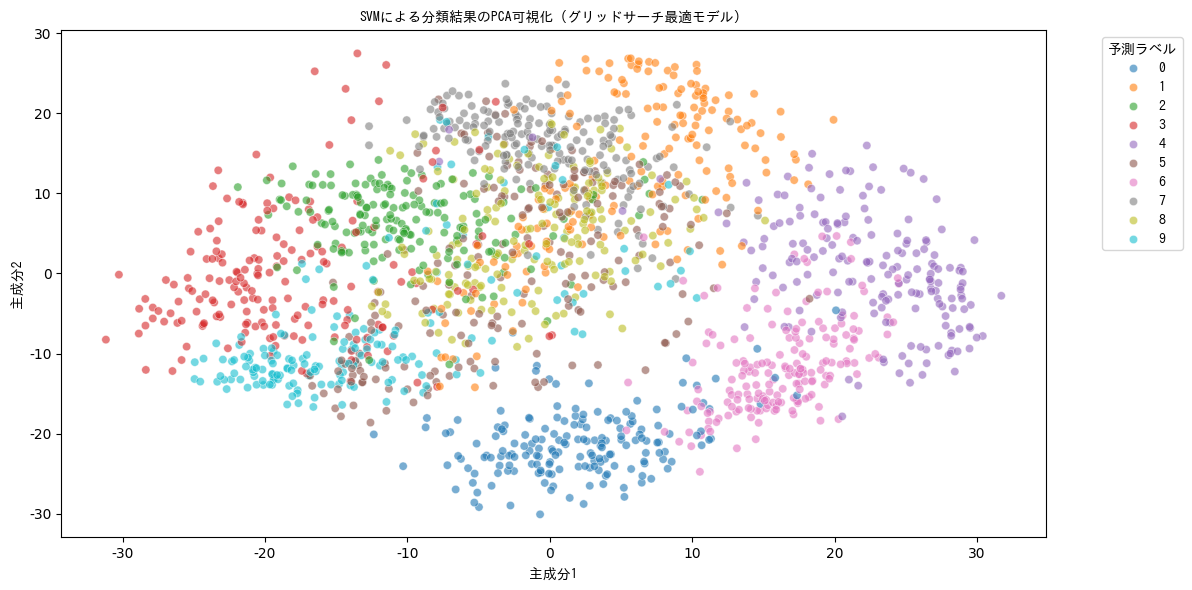

In [15]:
# 2次元プロット
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=all_pred, palette='tab10', alpha=0.6, legend='full')
plt.title("SVMによる分類結果のPCA可視化 (グリッドサーチ最適モデル)", fontproperties=ipa_font)
plt.xlabel("主成分1", fontproperties=ipa_font)
plt.ylabel("主成分2", fontproperties=ipa_font)
legend = plt.legend(title="予測ラベル", bbox_to_anchor=(1.05, 1), loc='upper left', prop=ipa_font)
legend.get_title().set_fontproperties(ipa_font)
plt.tight_layout()
plt.show()


分類ミス: 4 件


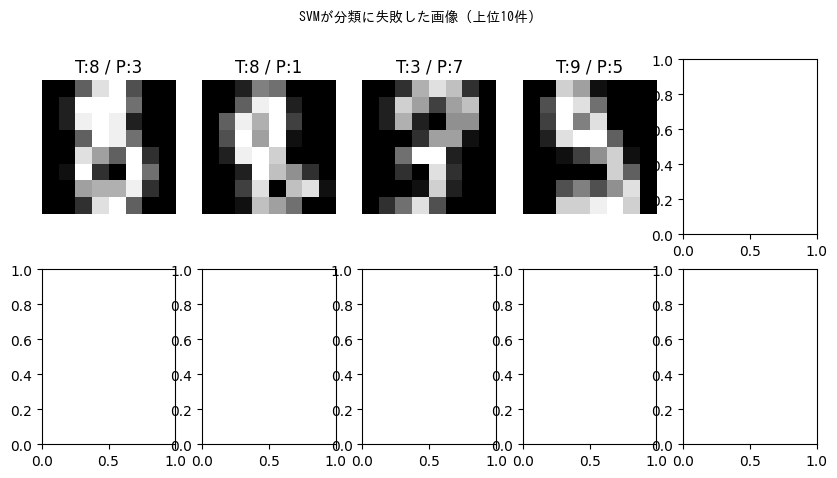

In [16]:
# 間違えた画像の可視化
wrong_indices = np.where(grid_pred != test_y)[0]
if len(wrong_indices) > 0:
    print(f"\n分類ミス: {len(wrong_indices)} 件")
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for ax, idx in zip(axes.ravel(), wrong_indices[:10]):
        ax.imshow(test_X[idx].reshape(8, 8), cmap='gray')
        ax.set_title(f"T:{test_y[idx]} / P:{grid_pred[idx]}")
        ax.axis("off")
    plt.suptitle("SVMが分類に失敗した画像 (上位10件)", fontproperties=ipa_font)
    plt.show()
else:
    print("分類ミスはありませんでした。")